In [ ]:
#For jum002 HPC setup
import sys
import os
sys.path.append("/home/jum002/store5/repo/smrt_fork/smrt")
sys.path.append("/home/jum002/store5/repo/snowmicropyn")
os.chdir("/home/jum002/code-workshop/AKROSS_paper/Code-paper")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
from scipy.stats import linregress


#local import
import akross_common_functions as AK

#SMRT import
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
#from smrt.permittivity.saline_snow import saline_snow_permittivity_geldsetzer09 as ssp
from smrt import make_model
from smrt.inputs import altimeter_list
from smrt.emmodel.iba import derived_IBA


#turn off warning
import warnings
warnings.simplefilter('ignore')
pd.set_option('mode.chained_assignment',None)

This notebook contains the following 4 sections

1. Align observation of waveform
2. prepare snowpack for simulation
3. Normalisation factor and roughness optimization
4. Simulation and observation comparison

### 1. Align Observation of Waveform

Import observation form pickle file and align to nominal gate of simulation.

In [4]:
#get obs
obs_CB = pd.read_pickle('smrt_in-out/observed_waveform_CB')
obs_E22 = pd.read_pickle('smrt_in-out/observed_waveform_E22')
obs_E16 = pd.read_pickle('smrt_in-out/observed_waveform_E16')
obs_A = pd.read_pickle('smrt_in-out/observed_waveform_A')

#get mean waveform
mean_obs_CB = obs_CB['mean']
mean_obs_E22 = obs_E22['mean']
mean_obs_E = obs_E16['mean']
mean_obs_A = obs_A['mean']

### 2. Prepare snowpack for simulation

- import profile derived from smp ready to inpu in SMRT simulation
- CB and Eureka22 have special pickle file of profile already prepare for input for SMRT. Pre processing was done to put smp density, ssa wiuth temperature and salinity from pit. For Eureak 16 and Alert, a similar process is done but smpr pofile are imported directly here

In [5]:
#Get smp from Eureka22
list_profile_E22 = pd.read_pickle('smrt_in-out/smp_profile_E22_3cm')
#get smp profile for CB
list_profile_CB = pd.read_pickle('smrt_in-out/smp_profile_CB_3cm')

# create list of SMRT snpwpack
CB_sp = AK.build_snowpack_pickle(list_profile_CB, ice_salinity = 10, ice_temp = 260, sea_ice_density = 910, 
                                    ice_type = 'firstyear', sigma_surface= 0.14)
E22_sp = AK.build_snowpack_pickle(list_profile_E22, ice_salinity = 10, ice_temp = 260, sea_ice_density = 910, 
                                    ice_type = 'firstyear', sigma_surface= 0.14)


In [6]:
#Get smp from Eureka16
list_profile_E = pd.read_pickle('smrt_in-out/smp_profile_E16_3cm')
#get smp profile for Alert
list_profile_A = pd.read_pickle('smrt_in-out/smp_profile_A_3cm')

# create list of SMRT snpwpack
E_sp = AK.build_snowpack_pickle(list_profile_E, ice_salinity = 5, ice_temp = 260, sea_ice_density = 880, 
                                    ice_type = 'multiyear', sigma_surface= 0.22)
A_sp = AK.build_snowpack_pickle(list_profile_A, ice_salinity = 5, ice_temp = 260, sea_ice_density = 880, 
                                    ice_type = 'multiyear', sigma_surface= 0.22)

In [7]:
print(f' Number of snowpack (or simulation) for CB : {len(CB_sp)},  Alert : {len(A_sp)}, Eureka 16 : {len(E_sp)}, Eureka 22 : {len(E22_sp)}')

 Number of snowpack (or simulation) for CB : 109,  Alert : 48, Eureka 16 : 546, Eureka 22 : 87


### 3. Find norm factor for rough surfaces

In [8]:
from smrt.core.globalconstants import C_SPEED
# find limit of surface model
k = 2*np.pi*13.575e9/C_SPEED
s_k_geo = 1/k
s_k_iem = 3/k
print(f'limit IEM {s_k_iem}, start GO {s_k_geo},')
k = 2*np.pi*35.75e9/C_SPEED
s_k_geo = 1/k
s_k_iem = 3/k
print(f'limit IEM {s_k_iem}, start GO {s_k_geo},')

limit IEM 0.010544409191683849, start GO 0.003514803063894616,
limit IEM 0.00400392600775128, start GO 0.0013346420025837603,


Optimization of the roughness

In [9]:
def simulate_waveform(s, l, norm_f, sp, contribution = False):
    """
    set mean roughness value for snow and ice from AKROSS campaign
    """
    
    AK.change_roughness(sp, s, l, s, l)
    
    #derived_IBA(ssp)
    altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(theta_inc_sampling=8, return_contributions=True),
                                                                    emmodel_options=dict(dense_snow_correction="auto"))
    cryosat = altimeter_list.cryosat2_sin()
    res = altimodel.run(cryosat, sp, parallel_computation=True).sigma()

    mean_simu = res.sel(contribution = 'total').mean( axis = 0).values * norm_f

    if contribution == True:
        mean_simu = res.mean(axis = 0) * norm_f

    return mean_simu


def log_waveform_residual_normf(p, sp, obs):
    """
    this is the least squares residual function for 
    log transformed data for the 4 sites

    index 160 so skip the noise part of the waveform
    """
    begin_index = 160
    end_index = -50

    res1 = np.log(simulate_waveform(p[0], p[1], p[2], sp[0])[begin_index:end_index]) - np.log(obs[0][begin_index:end_index])
    res2 = np.log(simulate_waveform(p[0], p[1], p[2], sp[1])[begin_index:end_index]) - np.log(obs[1][begin_index:end_index])
    res3 = np.log(simulate_waveform(p[0], p[1], p[2], sp[2])[begin_index:end_index]) - np.log(obs[2][begin_index:end_index])
    res4 = np.log(simulate_waveform(p[0], p[1], p[2], sp[3])[begin_index:end_index]) - np.log(obs[3][begin_index:end_index])

    return np.sqrt(res1**2 + res2**2 + res3**2 + res4**2)


def optimize_rough_normf(sp, obs, p0):
    """ 
    optimize using least square the two rough parameters for all site
    """

    # set bounds. helpful to constrain the otherwise difficult nonlinear optimization,

    bounds=([0.001, 0.01, 1e8], 
            [0.01, 0.37, 1e10])
   


    # least squares, use log transformed data, since the waveform contains values
    # separated by several orders of magnitude
    aux = optimize.least_squares(log_waveform_residual_normf, 
                                    p0, 
                                    bounds=bounds,
                                    method ='trf',
                                    #loss = 'soft_l1', 
                                    args=(sp, obs),
                                    verbose = 1)

    # get fit parameters
    popt = aux.x
    print(f'inital ice_rms : {popt[0]}, ice_lc : {popt[1]}')
    print(f'norm_factor : {popt[2]}')


    return popt


def log_waveform_residual_single(p, sp, obs, norm_f):
    """
    this is the least squares residual function for 
    log transformed data for 1 site

    index 160 so skip the noise part of the waveform
    """
    begin_index = 160
    end_index = -50
    return np.log(simulate_waveform(p[0], p[1], norm_f, sp)[begin_index:end_index]) - np.log(obs[begin_index:end_index])

def optimize_rough_single(sp, obs, normf, p0):
    """ 
    optimize using least sqaure the two rough parameters per site
    """

    # set bounds. helpful to constrain the otherwise difficult nonlinear optimization,

    bounds=([0.001, 0.01], 
            [0.01, 0.4])
   


    # least squares, use log transformed data, since the waveform contains values
    # separated by several orders of magnitude
    aux = optimize.least_squares(log_waveform_residual_single, 
                                    p0, 
                                    bounds=bounds,
                                    method ='trf',
                                    #loss = 'soft_l1',
                                    #loss = 'cauchy', 
                                    args=(sp, obs, normf))

    # get fit parameters
    popt = aux.x
    print(f'ice_rms : {popt[0]}, ice_lc : {popt[1]}')

    return popt

In [10]:

p0 = np.array([ 0.001, 0.2, 1e9])
#p0 = np.array([ 0.001, 0.5, 1e-9])
popt = optimize_rough_normf([CB_sp, E22_sp, E_sp, A_sp], 
                            [mean_obs_CB, mean_obs_E22, mean_obs_E, mean_obs_A],
                            p0)


`xtol` termination condition is satisfied.
Function evaluations 13, initial cost 9.4201e+02, final cost 8.4204e+02, first-order optimality 4.71e+03.
inital ice_rms : 0.0010000000539935547, ice_lc : 0.2851492585550277
norm_factor : 580491519.1349363


In [11]:
p0 = np.array([popt[0], popt[1]])
cryosat_norm_factor = popt[2]

popt_CB = optimize_rough_single(CB_sp, mean_obs_CB, cryosat_norm_factor, p0)
popt_E22 = optimize_rough_single(E22_sp, mean_obs_E22, cryosat_norm_factor, p0)


ice_rms : 0.002099884065392426, ice_lc : 0.3999999999981269
ice_rms : 0.0016304605732938421, ice_lc : 0.3999999999999863


In [12]:
#increase first guess, helps to converge to a better final solution
popt_E = optimize_rough_single(E_sp, mean_obs_E, cryosat_norm_factor, p0 + 0.003)
popt_A = optimize_rough_single(A_sp, mean_obs_A, cryosat_norm_factor, p0 + 0.003)



ice_rms : 0.0048982073042870816, ice_lc : 0.3999999999999871
ice_rms : 0.005655658832317991, ice_lc : 0.39999999999999986


### 4. Plot simulation and observation of waveform

Set simulation with constant roughness of normalisation factor

In [13]:
rms_normf_opti = 0.003
mean_ice_lc = 0.4
mean_simu_CB_roughNorm = simulate_waveform(rms_normf_opti, mean_ice_lc, cryosat_norm_factor, CB_sp)
mean_simu_E22_roughNorm = simulate_waveform(rms_normf_opti, mean_ice_lc, cryosat_norm_factor, E22_sp)
mean_simu_E_roughNorm = simulate_waveform(rms_normf_opti, mean_ice_lc, cryosat_norm_factor, E_sp)
mean_simu_A_roughNorm = simulate_waveform(rms_normf_opti, mean_ice_lc, cryosat_norm_factor, A_sp)

Set simulation with optimized roughness

In [14]:
mean_simu_CB = simulate_waveform(popt_CB[0], popt_CB[1], cryosat_norm_factor, CB_sp)
mean_simu_E22 = simulate_waveform(popt_E22[0], popt_E22[1], cryosat_norm_factor, E22_sp)
mean_simu_E = simulate_waveform(popt_E[0], popt_E[1], cryosat_norm_factor, E_sp)
mean_simu_A = simulate_waveform(popt_A[0], popt_A[1], cryosat_norm_factor, A_sp)

Get norm residuals of the best simulated waveform  ( < 0.3 ) and Trailing edge decay

In [15]:
def norm_squared_residual(sim, obs):
    """
    this is the least squares residual function for 
    log transformed data
    index 160 so skip the noise part of the waveform
    """
    #return simulate_waveform(p, sp)[160:-50] - obs[160:-50]
    return ((sim[160:-50] - obs[160:-50])**2).sum()/(obs[160:-50]**2).sum()
    #return ((sim - obs)**2/obs).sum()

In [16]:
def get_log_slope(obs):
    trailing_edge = obs[168:-50]
    regress = linregress(np.arange(len(trailing_edge)), np.log(trailing_edge))
    return regress.slope

In [17]:
nres_A = norm_squared_residual(mean_simu_A, mean_obs_A)
nres_CB = norm_squared_residual(mean_simu_CB, mean_obs_CB)
nres_E22 = norm_squared_residual(mean_simu_E22, mean_obs_E22)
nres_E = norm_squared_residual(mean_simu_E, mean_obs_E)
print(f' nres Cambay : {nres_CB},  nres Eureka 22 : {nres_E22}, nres Alert : {nres_A}, nres Eureka 16 : {nres_E}')

slope_A = get_log_slope(mean_obs_A)
slope_CB = get_log_slope(mean_obs_CB)
slope_E22 = get_log_slope(mean_obs_E22)
slope_E = get_log_slope(mean_obs_E)
print(f' decay slope Cambay : {slope_CB},  decay slope Eureka 22 : {slope_E22}, decay slope Alert : {slope_A}, decay slope Eureka 16 : {slope_E}')
17

 nres Cambay : 0.3348796309085695,  nres Eureka 22 : 0.26932992836908637, nres Alert : 0.017302032212560572, nres Eureka 16 : 0.036921161811461566
 decay slope Cambay : -0.02076778856355492,  decay slope Eureka 22 : -0.020637952521303685, decay slope Alert : -0.01671698088667977, decay slope Eureka 16 : -0.01802539627838147


17

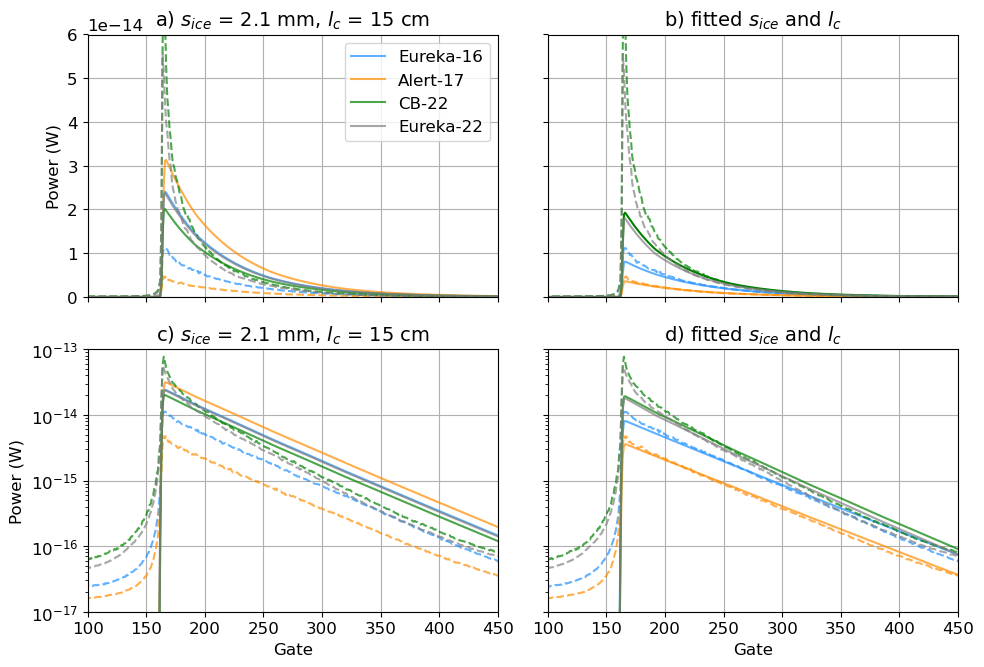

In [18]:
# Plot results
plt.close()
plt.rcParams.update({'font.size': 12})
fig, ((ax1, ax2), (ax3, ax4))   = plt.subplots(nrows=2, ncols=2, figsize=(10,7), sharex=True, sharey = 'row')

#Eureka normf roughness
ax1.plot(mean_simu_E_roughNorm , color = 'dodgerblue', alpha = 0.7, label='Eureka-16')
ax1.plot(mean_obs_E, 'b-', linestyle = '--', color = 'dodgerblue', alpha = 0.7)

#Alert normf roughness 
ax1.plot(mean_simu_A_roughNorm, color = 'darkorange', alpha = 0.7, label='Alert-17')
ax1.plot(mean_obs_A, 'b-', linestyle = '--', color = 'darkorange', alpha = 0.7)

#CB normf roughness
ax1.plot(mean_simu_CB_roughNorm, color = 'green', alpha = 0.7, label='CB-22')
ax1.plot(mean_obs_CB, 'b-', linestyle = '--', color = 'green', alpha = 0.7)

#E22 normf roughness
ax1.plot(mean_simu_E22_roughNorm, color = 'grey', alpha = 0.7, label='Eureka-22')
ax1.plot(mean_obs_E22, 'b-', linestyle = '--', color = 'grey', alpha = 0.7)

ax1.set_ylabel('Power (W)', size = 12)
#ax1.set_yscale('log')
ax1.legend()
#ax1.set_xlim(0, 450)
ax1.set_ylim(0, 0.6e-13)
ax1.grid()




#Eureka optimized roughness
ax2.plot(mean_simu_E, color = 'dodgerblue', alpha = 0.7)
ax2.plot(mean_obs_E, 'b-', linestyle = '--', color = 'dodgerblue', alpha = 0.7)

#Alert optimized roughness 
ax2.plot(mean_simu_A, color = 'darkorange', alpha = 0.7 )
ax2.plot(mean_obs_A, 'b-', linestyle = '--', color = 'darkorange', alpha = 0.7)

#CB optimized roughness
ax2.plot(mean_simu_CB, color = 'Green')
ax2.plot(mean_obs_CB, linestyle = '--', color = 'Green', alpha = 0.7)

#E22 optimized roughness
ax2.plot(mean_simu_E22, color = 'grey', alpha = 0.7, label='Eureka-22')
ax2.plot(mean_obs_E22, 'b-', linestyle = '--', color = 'grey', alpha = 0.7)

#ax2.set_yscale('log')
ax2.grid()
ax2.set_ylim(0, 0.6e-13)


#Eureka normf roughness
ax3.plot(mean_simu_E_roughNorm , color = 'dodgerblue', alpha = 0.7, label='Eureka-16')
ax3.plot(mean_obs_E, 'b-', linestyle = '--', color = 'dodgerblue', alpha = 0.7)

#Alert normf roughness 
ax3.plot(mean_simu_A_roughNorm, color = 'darkorange', alpha = 0.7, label='Alert-17')
ax3.plot(mean_obs_A, 'b-', linestyle = '--', color = 'darkorange', alpha = 0.7)

#CB normf roughness
ax3.plot(mean_simu_CB_roughNorm, color = 'green', alpha = 0.7, label='CB-22')
ax3.plot(mean_obs_CB, 'b-', linestyle = '--', color = 'green', alpha = 0.7)

#E22 normf roughness
ax3.plot(mean_simu_E22_roughNorm, color = 'grey', alpha = 0.7, label='Eureka-22')
ax3.plot(mean_obs_E22, 'b-', linestyle = '--', color = 'grey', alpha = 0.7)

ax3.set_ylabel('Power (W)', size = 12)
ax3.set_yscale('log')
#ax3.legend()
#ax3.set_xlim(0, 450)
ax3.set_ylim(0, 0.6e-13)
ax3.set_xlabel('Gate')
ax3.grid()




#Eureka  optimized roughness
ax4.plot(mean_simu_E , color = 'dodgerblue', alpha = 0.7, label='Eureka-16')
ax4.plot(mean_obs_E, 'b-', linestyle = '--', color = 'dodgerblue', alpha = 0.7)

#Alert  optimized roughness
ax4.plot(mean_simu_A, color = 'darkorange', alpha = 0.7, label='Alert-17')
ax4.plot(mean_obs_A, 'b-', linestyle = '--', color = 'darkorange', alpha = 0.7)

#CB  optimized roughness
ax4.plot(mean_simu_CB, color = 'green', alpha = 0.7, label='CB-22')
ax4.plot(mean_obs_CB, 'b-', linestyle = '--', color = 'green', alpha = 0.7)

#E22 optimized roughness
ax4.plot(mean_simu_E22, color = 'grey', alpha = 0.7, label='Eureka-22')
ax4.plot(mean_obs_E22, 'b-', linestyle = '--', color = 'grey', alpha = 0.7)

#ax4.set_ylabel('Backscatter', size = 12)
ax4.set_xlabel('Gate')
ax4.set_yscale('log')
ax4.set_ylim(1e-17, 1e-13)
ax4.grid()



ax1.set_title('a) $s_{ice}$ = 2.1 mm, $l_c$ = 15 cm', size = 14)
ax3.set_title('c) $s_{ice}$ = 2.1 mm, $l_c$ = 15 cm', size = 14)

ax2.set_title('b) fitted $s_{ice}$ and $l_c$ ', size = 14)
ax4.set_title('d) fitted $s_{ice}$ and $l_c$ ', size = 14)


ax1.set_xlim(100, 450)
plt.tight_layout()
#plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/sites_waveform_rough_opti_incsample.png', dpi=300, format='png', bbox_inches='tight')

In [19]:
mean_simu_CB = simulate_waveform(popt_CB[0], popt_CB[1], cryosat_norm_factor, CB_sp, contribution = True)
mean_simu_E22 = simulate_waveform(popt_E22[0], popt_E22[1], cryosat_norm_factor, E22_sp, contribution = True)
mean_simu_E = simulate_waveform(popt_E[0], popt_E[1], cryosat_norm_factor, E_sp, contribution = True)
mean_simu_A = simulate_waveform(popt_A[0], popt_A[1], cryosat_norm_factor, A_sp, contribution = True)

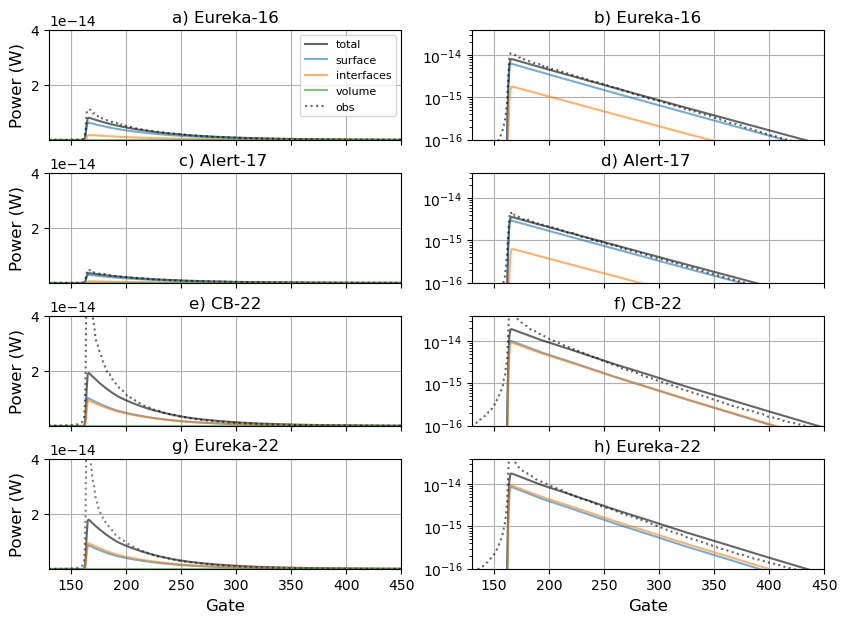

In [20]:
# Plot results
plt.close()
plt.rcParams.update({'font.size': 10})
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8))   = plt.subplots(nrows=4, ncols=2, figsize=(10,7), sharex=True, sharey = 'col')

#Eureka normf roughness
ax1.plot(mean_simu_E.sel(contribution = 'total'), alpha = 0.6, label='total', color = 'k')
ax1.plot(mean_simu_E.sel(contribution = 'surface') , alpha = 0.6, label='surface')
ax1.plot(mean_simu_E.sel(contribution = 'interfaces') , alpha = 0.6, label='interfaces')
ax1.plot(mean_simu_E.sel(contribution = 'volume'), alpha = 0.6, label='volume')
ax1.plot(mean_obs_E, 'b-', linestyle = ':', color = 'k', alpha = 0.6, label = 'obs')

#Eureka normf roughness
ax2.plot(mean_simu_E.sel(contribution = 'total'), alpha = 0.6, label='total', color = 'k')
ax2.plot(mean_simu_E.sel(contribution = 'surface') , alpha = 0.6, label='surface')
ax2.plot(mean_simu_E.sel(contribution = 'interfaces') , alpha = 0.6, label='interfaces')
ax2.plot(mean_simu_E.sel(contribution = 'volume'), alpha = 0.6, label='volume')
ax2.plot(mean_obs_E, 'b-', linestyle = ':', color = 'k', alpha = 0.6, label = 'obs')

#Alert normf roughness 
ax3.plot(mean_simu_A.sel(contribution = 'total'), alpha = 0.6, label='total', color = 'k')
ax3.plot(mean_simu_A.sel(contribution = 'surface') , alpha = 0.6, label='surface')
ax3.plot(mean_simu_A.sel(contribution = 'interfaces') , alpha = 0.6, label='interfaces')
ax3.plot(mean_simu_A.sel(contribution = 'volume'), alpha = 0.6, label='volume')
ax3.plot(mean_obs_A, 'b-', linestyle = ':', color = 'k', alpha = 0.6)

#Alert normf roughness 
ax4.plot(mean_simu_A.sel(contribution = 'total'), alpha = 0.6, label='total', color = 'k')
ax4.plot(mean_simu_A.sel(contribution = 'surface') , alpha = 0.6, label='surface')
ax4.plot(mean_simu_A.sel(contribution = 'interfaces') , alpha = 0.6, label='interfaces')
ax4.plot(mean_simu_A.sel(contribution = 'volume'), alpha = 0.6, label='volume')
ax4.plot(mean_obs_A, 'b-', linestyle = ':', color = 'k', alpha = 0.6)

#CB normf roughness
ax5.plot(mean_simu_CB.sel(contribution = 'total'), alpha = 0.6, label='total', color = 'k')
ax5.plot(mean_simu_CB.sel(contribution = 'surface') , alpha = 0.6, label='surface')
ax5.plot(mean_simu_CB.sel(contribution = 'interfaces') , alpha = 0.6, label='interfaces')
ax5.plot(mean_simu_CB.sel(contribution = 'volume'), alpha = 0.6, label='volume')
ax5.plot(mean_obs_CB, 'b-', linestyle = ':', color = 'k', alpha = 0.6)

#CB normf roughness
ax6.plot(mean_simu_CB.sel(contribution = 'total'), alpha = 0.6, label='total', color = 'k')
ax6.plot(mean_simu_CB.sel(contribution = 'surface') , alpha = 0.6, label='surface')
ax6.plot(mean_simu_CB.sel(contribution = 'interfaces') , alpha = 0.6, label='interfaces')
ax6.plot(mean_simu_CB.sel(contribution = 'volume'), alpha = 0.6, label='volume')
ax6.plot(mean_obs_CB, 'b-', linestyle = ':', color = 'k', alpha = 0.6)


#E22 normf roughness
ax7.plot(mean_simu_E22.sel(contribution = 'total'), alpha = 0.6, label='total', color = 'k')
ax7.plot(mean_simu_E22.sel(contribution = 'surface') , alpha = 0.6, label='surface')
ax7.plot(mean_simu_E22.sel(contribution = 'interfaces') , alpha = 0.6, label='interfaces')
ax7.plot(mean_simu_E22.sel(contribution = 'volume'), alpha = 0.6, label='volume')
ax7.plot(mean_obs_E22, 'b-', linestyle = ':', color = 'k', alpha = 0.5)

#E22 normf roughness
ax8.plot(mean_simu_E22.sel(contribution = 'total'), alpha = 0.6, label='total', color = 'k')
ax8.plot(mean_simu_E22.sel(contribution = 'surface') , alpha = 0.6, label='surface')
ax8.plot(mean_simu_E22.sel(contribution = 'interfaces') , alpha = 0.6, label='interfaces')
ax8.plot(mean_simu_E22.sel(contribution = 'volume'), alpha = 0.6, label='volume')
ax8.plot(mean_obs_E22, 'b-', linestyle = ':', color = 'k', alpha = 0.6)

ax1.set_ylabel('Power (W)', size = 12)
ax3.set_ylabel('Power (W)', size = 12)
ax5.set_ylabel('Power (W)', size = 12)
ax7.set_ylabel('Power (W)', size = 12)
ax7.set_xlabel('Gate', size = 12)
ax8.set_xlabel('Gate', size = 12)

ax1.legend(loc =1, prop ={'size' : 8})
ax1.set_xlim(130, 450)
ax1.set_ylim(1e-16, 0.4e-13)
ax2.set_yscale('log')
ax2.set_ylim(1e-16, 0.4e-13)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax5.grid()
ax6.grid()
ax7.grid()
ax8.grid()


ax1.set_title('a) Eureka-16', size = 12)
ax3.set_title('c) Alert-17 ', size = 12)
ax5.set_title('e) CB-22', size = 12)
ax7.set_title('g) Eureka-22', size = 12)

ax2.set_title('b) Eureka-16', size = 12)
ax4.set_title('d) Alert-17 ', size = 12)
ax6.set_title('f) CB-22', size = 12)
ax8.set_title('h) Eureka-22', size = 12)

fig.subplots_adjust(hspace = 0.3)